In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import feature_extraction, linear_model, model_selection, preprocessing

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [12]:
train_df["word_count"] = train_df["text"].apply(lambda x: len(x.split()))
test_df["word_count"] = test_df["text"].apply(lambda x: len(x.split()))
train_df["mean_word_length"] = train_df["text"].apply(lambda x: np.mean([len(f) for f in x.split()]))
test_df["mean_word_length"] = test_df["text"].apply(lambda x: np.mean([len(f) for f in x.split()]))

In [13]:
with pd.option_context('display.max_colwidth',100):
    display(train_df[train_df.target == 0].head())
    display(train_df[train_df.target == 1].head())

,id,keyword,location,text,target,word_count,mean_word_length
15,23,NaN,NaN,What's up man?,0,3,4.000000
16,24,NaN,NaN,I love fruits,0,3,3.666667
17,25,NaN,NaN,Summer is lovely,0,3,4.666667
18,26,NaN,NaN,My car is so fast,0,5,2.600000
19,28,NaN,NaN,What a goooooooaaaaaal!!!!!!,0,3,8.666667


,id,keyword,location,text,target,word_count,mean_word_length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,13,4.384615
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,4.571429
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1,22,5.090909
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1,8,7.125000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,16,4.500000


# Word lengths and word counts

Simple feature which shows average length of words and number of words in a tweet

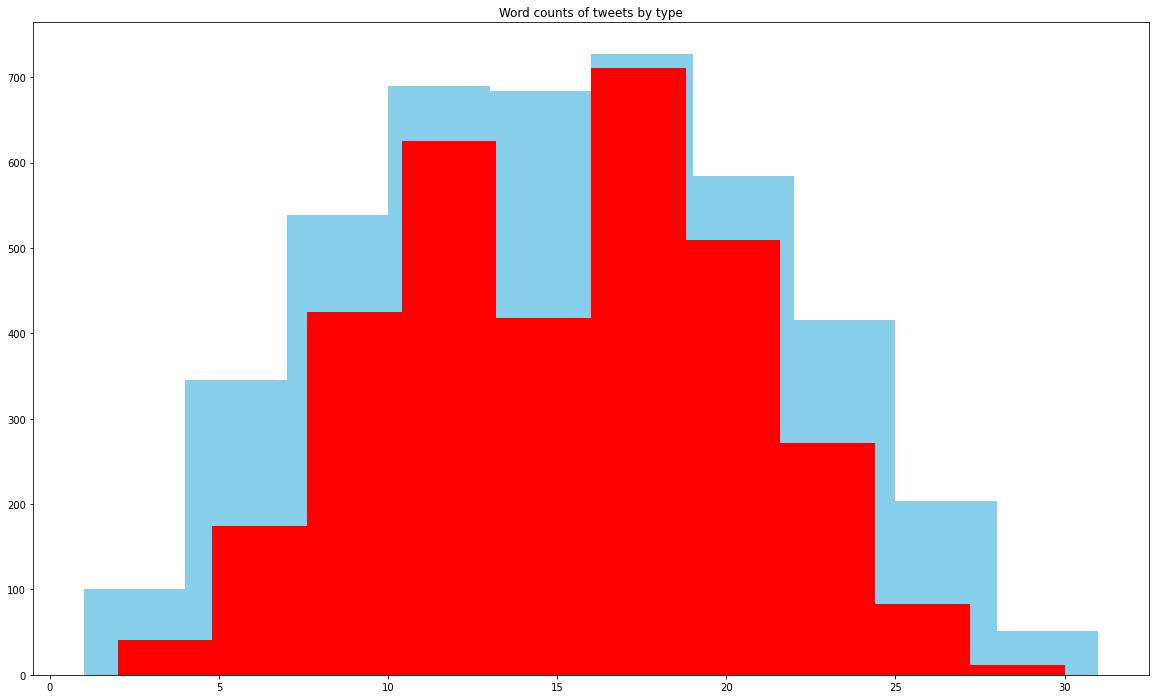

In [26]:
plt.figure(figsize=(20,12))
plt.title("Word counts of tweets by type")
plt.hist(train_df[train_df.target==0]["word_count"],color="skyblue",label="Not disaster tweets")
plt.hist(train_df[train_df.target==1]["word_count"],color="red",label="Disaster tweets")
plt.savefig("word_counts.png")

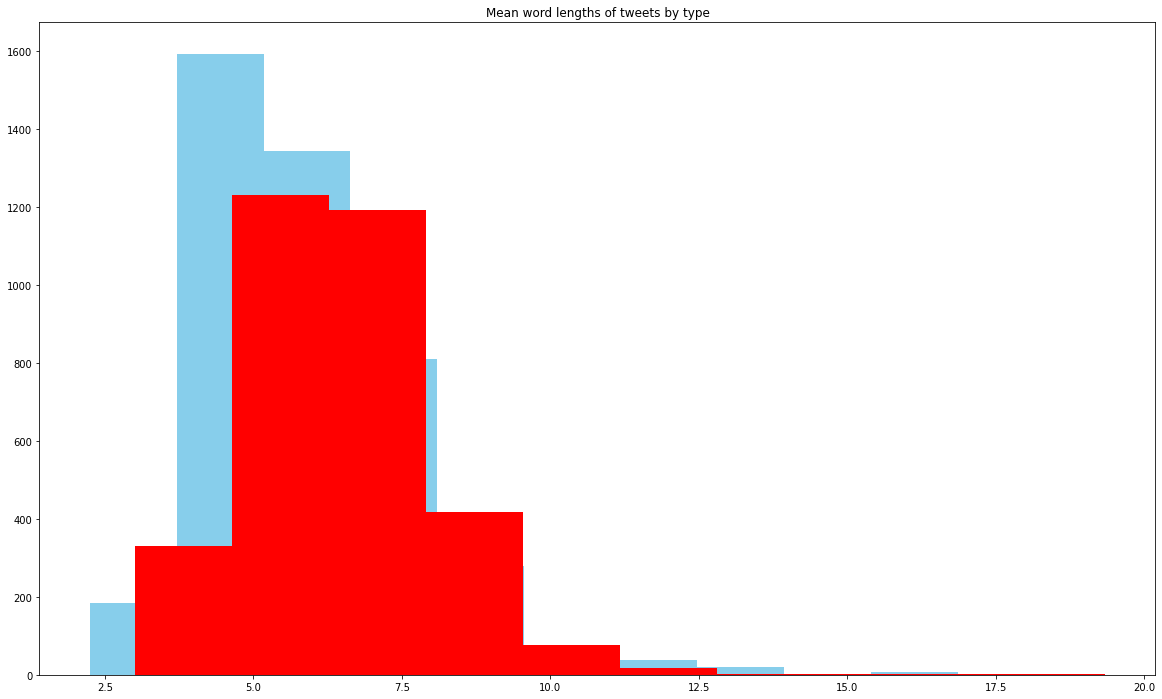

In [27]:
plt.figure(figsize=(20,12))
plt.title("Mean word lengths of tweets by type")
plt.hist(train_df[train_df.target==0]["mean_word_length"],color="skyblue",label="Not disaster tweets")
plt.hist(train_df[train_df.target==1]["mean_word_length"],color="red",label="Disaster tweets")
plt.savefig("word_lengths.png")

In [57]:
classifier0 = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(classifier0,train_df[["word_count","mean_word_length"]],train_df["target"].values,cv=5,scoring="f1")

In [58]:
scores

array([0.30252101, 0.38549618, 0.36494845, 0.39922481, 0.37365011])

In [60]:
classifier0.fit(train_df[["word_count","mean_word_length"]],train_df["target"])

RidgeClassifier()

In [61]:
submission_0 = pd.read_csv("sample_submission.csv")
submission_0["target"] = classifier0.predict(test_df[["word_count","mean_word_length"]])
submission_0.to_csv("submission_0.csv",index=False)

# 1. Vectorizing words

Count all unique words from all training set tweets, and for each tweet, return a vector with the count number of those words.  

In [42]:
word_vectorizer = feature_extraction.text.CountVectorizer()

In [43]:
train_df["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [44]:
train_vectors = word_vectorizer.fit_transform(train_df["text"])
test_vectors = word_vectorizer.transform(test_df["text"])

In [45]:
classifier1_ridge = linear_model.RidgeClassifier()
scores = model_selection.cross_val_score(classifier1_ridge,train_vectors,train_df["target"],cv=5,scoring="f1")

In [46]:
scores

array([0.6025641 , 0.50168919, 0.56985004, 0.50781969, 0.67326733])

In [98]:
classifier1_ridge.fit(train_vectors,train_df["target"])

RidgeClassifier()

In [100]:
submission_1 = pd.read_csv("sample_submission.csv")
submission_1["target"] = classifier1_ridge.predict(test_vectors)

In [102]:
submission_1.to_csv("submission_1.csv",index=False)